<a href="https://colab.research.google.com/github/robson-rsp/datascience/blob/main/timeseries/store_item_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Store Item Demand Forecasting

# Initial imports

In [ ]:
%pip install ipython-autotime  --upgrade
%pip install scikit-learn      --upgrade

In [1]:
from google.colab import drive, files
import pandas as pd
import warnings
drive.mount('/content/drive', force_remount=True)
warnings.filterwarnings("ignore")
%load_ext autotime

Mounted at /content/drive
time: 682 µs (started: 2023-05-07 00:39:45 +00:00)


In [2]:
dataset = pd.read_csv("/content/drive/MyDrive/datasets/store-item-demand-forecasting/train.csv", encoding='utf-8', parse_dates=['date'])

time: 1.41 s (started: 2023-05-07 00:39:51 +00:00)


# EDA

In [ ]:
dataset

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


time: 15.4 ms (started: 2023-05-05 14:17:37 +00:00)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
time: 76.9 ms (started: 2023-05-05 14:17:50 +00:00)


In [ ]:
dataset.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


time: 193 ms (started: 2023-05-05 14:17:57 +00:00)


## Data visualization

In [ ]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

time: 5.63 ms (started: 2023-05-05 14:22:33 +00:00)


# Train/Test split

In [3]:
from sklearn.model_selection import TimeSeriesSplit

time: 949 ms (started: 2023-05-07 00:39:56 +00:00)


In [ ]:
tss = TimeSeriesSplit(n_splits=2)
folds = tss.split(dataset)

next(folds)
train_indexes, test_indexes = next(folds) # só o último fold me interessa pois é o maior

train_set = dataset.iloc[train_indexes]
test_set  = dataset.iloc[test_indexes]

# a única alteração que farei nestes conjuntos será renomear suas colunas para serems usados no Prophet
train_set_prophet = train_set.copy()
test_set_prophet  = test_set.copy()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True)

axs.axvline(test_set.index.min(), color='black', ls='--')
sns.scatterplot(x=train_set.index, y=train_set['sales'], ax=axs, alpha=0.04)
sns.scatterplot(x=test_set.index, y=test_set['sales'], ax=axs, alpha=0.04)
  
plt.tight_layout()
plt.show()

# Feature engineering.

In [ ]:
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import OrdinalEncoder
     
import math
import numpy as np

time: 593 µs (started: 2023-05-05 13:40:51 +00:00)


**Etapa ##:** Mantenho somente os anos e meses nas datas.

In [4]:
#dataset['date'] = dataset['date'].dt.strftime('%Y-%m') # o novo atributo se transforma em object.
#dataset["date"] = pd.to_datetime(dataset["date"])

dataset['date'] = dataset['date'].dt.to_period('M') # o novo atributo se transforma em period[M].
dataset['date'] = pd.PeriodIndex(dataset['date'], freq='M').to_timestamp()

time: 206 ms (started: 2023-05-07 00:40:32 +00:00)


**Etapa ##:** Somo a quantidade de vendas de cada item em cada loja mensalmente.

In [5]:
dataset = dataset.groupby(['store', 'item', 'date'])['sales'].sum().reset_index()
dataset = dataset[['date', 'store', 'item', 'sales']] # reordeno as colunas apenas para ficar mais legível

time: 293 ms (started: 2023-05-07 00:41:29 +00:00)


In [ ]:
mask = dataset['item'] == 1
dataset[mask]

,date,store,item,sales
0,2013-01-01,1,1,328
1,2013-02-01,1,1,322
2,2013-03-01,1,1,477
3,2013-04-01,1,1,522
4,2013-05-01,1,1,531
...,...,...,...,...
27055,2017-08-01,10,1,945
27056,2017-09-01,10,1,865
27057,2017-10-01,10,1,861
27058,2017-11-01,10,1,860


time: 20.1 ms (started: 2023-05-05 14:37:16 +00:00)


**Etapa ##:** Crio as lag features. Para cada registro, adiciono a quantidade de vendas feitas no primeiro, segundo e terceiro mês seguinte. Portanto, não são exatamente "lag" features, mas sim "forward". 

In [ ]:
# Create the lag features for each of the past three sales months
train['sales_forward_1'] = train.groupby(['store', 'item'])['sales'].shift(-1)
train['sales_forward_2'] = train.groupby(['store', 'item'])['sales'].shift(-2)
train['sales_forward_3'] = train.groupby(['store', 'item'])['sales'].shift(-3)

time: 13.6 ms (started: 2023-05-05 13:40:52 +00:00)


**Etapa ##:** Extraio novos atributos a partir das datas.
1.   Ano
2.   Mês
4.   Estações do ano;
5.   Quartis de cada ano.


In [ ]:
def get_season(month):
  if month in [12, 1, 2]:
    return "Winter"
  elif month in [3, 4, 5]:
    return "Spring"
  elif month in [6, 7, 8]:
    return "Summer"
  else:
    return "Fall"



#train = train.assign(season=train["date"].dt.month.map(get_season))
train['year']    = train['date'].dt.year
train['month']   = train['date'].dt.month
train['season']  = np.vectorize(get_season)(train['date'].dt.month)
train['quarter'] = train['date'].dt.to_period('Q')

time: 51.4 ms (started: 2023-05-05 13:40:52 +00:00)


**Etapa ##:** O conjunto de dados possui datas de 2013 até 2017 se repetindo em forma de ciclos inúmeras vezes. Isso acontece por causa das lojas e itens. Para fazer com que os modelos de machine learning entendam esses ciclos eu codifico os atributos cíclicos(year, month, season, quarter) decompondo-os em componentes seno e conseno. Só depois disso posso remover o atributo 'date' do conjunto.

In [ ]:
class CyclicEncoder(BaseEstimator, TransformerMixin):
  """
  Esta classe deve ser usada sozinha ou dentro de um Pipeline.
  """
  def __init__(self, cyclical_cols):
    self.cyclical_cols = cyclical_cols

  def create_cyclic_names(self):
    cols_names = []
    for name in self.cyclical_cols:
      cols_names.append("sin_" + name)
      cols_names.append("cos_" + name)
    return cols_names
    
  def fit(self, X, y=None):
    ordinal_encoder = OrdinalEncoder()
    self.X_ordinal = ordinal_encoder.fit_transform(X[self.cyclical_cols])    
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X_aux = []
    cols = range(self.X_ordinal.shape[1])
    for index in cols:
      column = self.X_ordinal[:, index]
      max_value = column.max()
      sin_values = [math.sin((2 * math.pi * x) / max_value) for x in list(column)]
      cos_values = [math.cos((2 * math.pi * x) / max_value) for x in list(column)]
      X_aux.append(sin_values)
      X_aux.append(cos_values)
    X_encoded = np.array(X_aux).transpose()
    return pd.DataFrame(data=X_encoded, columns=self.create_cyclic_names())



ce = CyclicEncoder(['year', 'month', 'season', 'quarter'])
cyclical_features = ce.fit_transform(train)

time: 910 ms (started: 2023-05-05 13:40:52 +00:00)


**Etapa ##:** Formo um novo conjunto de treino com os atributos cíclicos.

Obs. Note que não seleciono todos os atributos de 'train' pois não são necessários.

In [ ]:
train = pd.concat([cyclical_features, train[['sales_forward_1', 'sales_forward_2', 'sales_forward_3', 'store', 'item', 'sales']]], axis=1)

time: 5.66 ms (started: 2023-05-05 13:40:53 +00:00)


**Etapa ##:** Removo os registros que contém NaN.

In [ ]:
train = train.dropna()

time: 10.4 ms (started: 2023-05-05 13:40:53 +00:00)


**Etapa ##:** Separo as labels do conjunto de dados.

In [ ]:
y_train = train[['sales_forward_1', 'sales_forward_2', 'sales_forward_3']]
X_train = train.drop(['sales_forward_1', 'sales_forward_2', 'sales_forward_3'], axis=1)

time: 8.84 ms (started: 2023-05-05 13:40:53 +00:00)


# Model training
Para cada tipo de modelo vou treinar três instâncias diferentes. Cada instância vai prever um mês diferente à frente.

1.   modelo_a: 1 mês à frente;
2.   modelo_b: 2 meses à frente;
3.   modelo_c: 3 meses à frente.



In [ ]:
from sklearn.base     import clone
from sklearn.metrics  import mean_squared_error
from xgboost          import XGBRegressor

import lightgbm as lgb
import numpy as np

time: 697 µs (started: 2023-05-05 13:40:53 +00:00)


## Custom cross validation

In [ ]:
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error between the true and predicted values.   
    
    Returns (The lower the better):
    float: The SMAPE score between 0 and 100.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    numerator = np.abs(y_pred - y_true)
    
    return np.mean(numerator / denominator) * 100

time: 888 µs (started: 2023-05-05 13:40:53 +00:00)


In [ ]:
def custom_cross_val(model, dataset, pipeline, label_name):
  scores = list()
  tss = TimeSeriesSplit(n_splits=5)
  for train_indexes, val_indexes in tss.split(dataset):
    train_set       = dataset.iloc[train_indexes]
    validation_set  = dataset.iloc[val_indexes]

    if pipeline:
      train_set       = pipeline.fit_transform(train_set)
      validation_set  = pipeline.transform(validation_set)

    y_train = train_set[label_name]
    X_train = train_set.drop(label_name, axis=1)

    y_val = validation_set[label_name]
    X_val = validation_set.drop(label_name, axis=1)

    model_clone = clone(model)
    model_clone.fit(X_train, y_train)
    y_pred = model_clone.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)
  return scores

time: 1.25 ms (started: 2023-05-05 13:40:53 +00:00)


Abaixo, a visualização dos folds que serão usados na validação cruzada.

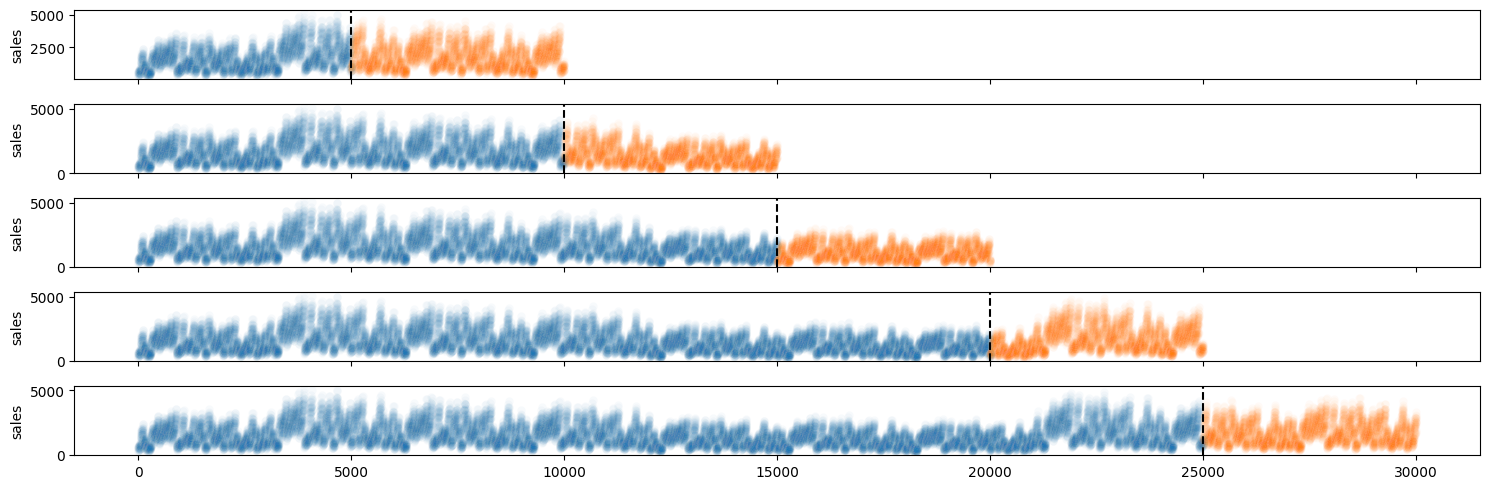

time: 2.56 s (started: 2023-05-05 13:40:53 +00:00)


In [ ]:
tss = TimeSeriesSplit(n_splits=5)

fig, axs = plt.subplots(5, 1, figsize=(15, 5), sharex=True)
axs = axs.ravel()
index = 0

for train_indexes, test_indexes in tss.split(train):
  train_set = train.iloc[train_indexes]
  test_set  = train.iloc[test_indexes]
  axs[index].axvline(test_set.index.min(), color='black', ls='--')
  sns.scatterplot(x=train_set.index, y=train_set['sales'], ax=axs[index], alpha=0.03)
  sns.scatterplot(x=test_set.index, y=test_set['sales'], ax=axs[index], alpha=0.03)
  index += 1
  
plt.tight_layout()
plt.show()

## LGBMRegressor

In [ ]:
scores = custom_cross_val(lgb.LGBMRegressor(), train, None, 'sales')
print(f'Mean RMSE: {np.mean(scores):.2f}')
print(f'Std Dev:   {np.std(scores):.2f}')

Mean RMSE: 54.35
Std Dev:   4.65
time: 1.89 s (started: 2023-05-05 13:40:55 +00:00)


In [ ]:
# Train separate LightGBM models for each target variable
lgbm_l1 = lgb.LGBMRegressor()
lgbm_l2 = lgb.LGBMRegressor()
lgbm_l3 = lgb.LGBMRegressor()

lgbm_l1.fit(X_train, y_train.iloc[:,0])
lgbm_l2.fit(X_train, y_train.iloc[:,1])
lgbm_l3.fit(X_train, y_train.iloc[:,2])

# Make predictions on the test data
y_pred_l1 = lgbm_l1.predict(X_train)
y_pred_l2 = lgbm_l2.predict(X_train)
y_pred_l3 = lgbm_l3.predict(X_train)
y_pred = np.column_stack((y_pred_l1, y_pred_l2, y_pred_l3))

# Evaluate the model using SMAPE
smape_score = smape(y_train, y_pred)
print("SMAPE score: {:.2f}%".format(smape_score))

SMAPE score: 3.20%
time: 1.21 s (started: 2023-05-05 13:45:52 +00:00)


In [ ]:
# Make predictions on the test data
y_pred_l1 = lgbm_l1.predict(X_test)
y_pred_l2 = lgbm_l2.predict(X_test)
y_pred_l3 = lgbm_l3.predict(X_test)
y_pred = np.column_stack((y_pred_l1, y_pred_l2, y_pred_l3))

# Evaluate the model using SMAPE
smape_score = smape(y_train, y_pred)
print("SMAPE score: {:.2f}%".format(smape_score))

## XGBRegressor

In [ ]:
scores = custom_cross_val(XGBRegressor(), train, None, 'sales')
print(f'Mean RMSE: {np.mean(scores):.2f}')
print(f'Std Dev:   {np.std(scores):.2f}')

In [ ]:
n_samples = len(train)
print(n_samples)
print(n_samples // 5)
print(((n_samples // 5) / n_samples) * 100)

In [ ]:
print(n_samples /5)
print((n_samples/ 5) * 0.25)